<a href="https://colab.research.google.com/github/syifaapr/Capstone/blob/main/capstone_effi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'efficientnet-keras-weights-b0b5:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F266957%2F556303%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240528%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240528T062757Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D45995894ee28583c35c1a3b97f085a15145a5c1b61411ccccbb9e0fe09d981bf8eacb3700fca1d2b0598b2a776cc5905b6aaf64457509468ab6195c3111a335ec63e3e28ca3d1d179b086ac73786a425f1e7109abda3824037c1ccd58e95ed2473811d6e78df89d7af671a400977dabf64b93549132f4b2941410d595b73e86e509efab7e6ab6350de1305f637de01b14f0ecab368cc6a019d19c3de5b722455c0db672f9e30b43cf5f95093b108fd961dd66b765fbc6a2c4928f4709da443ddb3d8971ed265f91d5f95bf751367e7ea03c4bc4d4f8cba20d8b356c87ee085c9692bc4530b850f941f90849101585f26e40e8e99a5e647fea4e8acf6c745e085,skin-diseases-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1532614%2F2529450%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240528%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240528T062757Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4c28ef13010680fa5ab050da7a3f3ac645b15b7275afba709cf70cc1756d2f542ef001d6f811d8666b4c8ff1c751997039359f743ce89638d1bd2a1f5e85c3d902dd2041a1d58ea6c7f68627afed34b4a6732150a8cc0640f23c63ff754c8879685a8f4f1b104cd88ab212e6608329946d4afd4ba3611c5df975700a71e72b712a2d25a733d8b346ff5831b6d111e69227bd94a1183bac4b0e8ff09a907541d843b0b3c484b491688119eb8d35188656c493c6d617b00f2e68d2e9369adc876ac090ab06cde53820e8d3b40f86550c8e49835a5ac384758b98948d0f5b545fda508ff6dd85dbf27150b96ca718110c59e8f004e703942e919afb0e25347b20bf,syifa-efficientnet-b3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5098834%2F8536243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240528%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240528T062757Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c816fb9341f89528ab79dc13acf81ae08447139c48ffc0716cb165577f4e5e553891448d95f2fc11a796c5ef656bad397d9e2e4c45018e317dbf1dc5b97ef800704ee0ff29340fe7a3807b4e9306aa7b09c4bc7b32b89e751391c4d4141ad32a12b1d22faeccfdde295bb75447f49adf2810b75fd702fffe2e5d1d94730381b6819ca1cace89edbcc6b5d456155ccf38669811ce23ffb72cb79a4042bc7527c78e807c759149116173bc453ef3a73d9f31bab2e60fd20044d9ee0fe4df15a13a3d0de18f44ab12a143284f6b3455cec374498d931f056732844096eed14c569b292abb2825903296f64641d6e2d57dcb0750f43df9a988115c2993dbc2a9491'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/syifa-efficientnet-b3/efficientnetb2_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b4_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b0_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b2_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b1_imagenet_1000_notop.h5
/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b3_imagenet_1000_notop.h5
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-factitial-dermatitis-1.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/v-eczema-areola-13.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-subacute-66.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-hand-86.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1.

In [ ]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

In [ ]:
data_path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'

In [ ]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))

    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

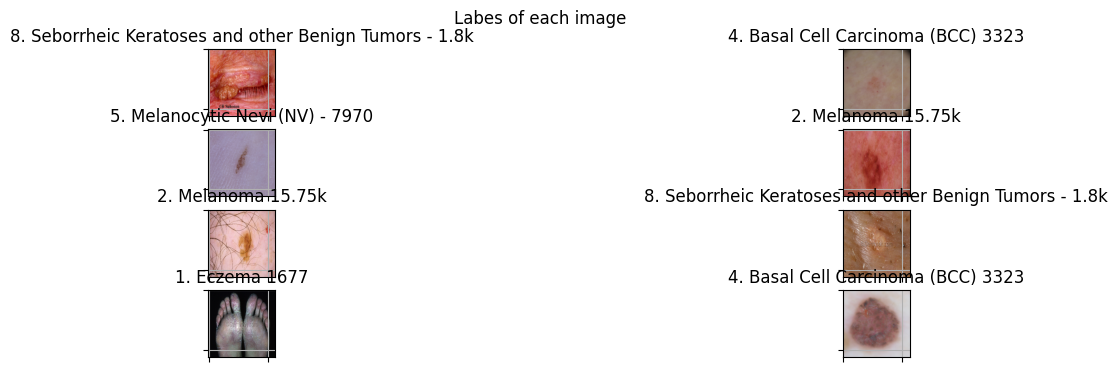

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 4))
plt.suptitle('Labes of each image')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
import os

local_weights_path = '/kaggle/input/syifa-efficientnet-b3/efficientnetb2_notop.h5'
if not os.path.exists(local_weights_path):
    raise FileNotFoundError(f"The weights file was not found at {local_weights_path}")

base_model = EfficientNetB2(weights=local_weights_path, include_top=False, input_shape=(224, 224, 3))


In [ ]:
base_model.trainable = False

In [ ]:
num_classes = 10
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# train_data = [(preprocess_input(input), label) for input, label in train_data]
# val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 16
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1482s 1s/step - accuracy: 0.5060 - loss: 1.3205 - val_accuracy: 0.6338 - val_loss: 0.9245
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1460s 1s/step - accuracy: 0.6523 - loss: 0.9059 - val_accuracy: 0.6752 - val_loss: 0.8315
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1456s 1s/step - accuracy: 0.6772 - loss: 0.8495 - val_accuracy: 0.6947 - val_loss: 0.7967
Epoch 4/10
 165/1358 ━━━━━━━━━━━━━━━━━━━━ 16:26 827ms/step - accuracy: 0.7287 - loss: 0.7498

In [ ]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy')
plt.plot(epochs, val_loss,label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()


plt.show()

In [ ]:
# Get the training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [ ]:
model.save('syifa.h5')